In [40]:
%matplotlib inline


In [41]:
import matplotlib.pyplot as plt
import matplotlib
import stistools
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np

In [42]:
import warnings
warnings.filterwarnings('ignore')


In [43]:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

In [169]:
#f_dict = {}
spec_log = Table(names = ['phase', 'name', 'file'], dtype = ['i4', 'U8', 'U64'])
for folder in glob.glob('./reduced_spectra/*'):
    objname = folder.split('/')[2]
    f_list = glob.glob(folder+'/*')
#    obj_dict = {}
    for df in f_list:
        t = int(re.findall(r'd\d+', df)[0][1:])
#        obj_dict[t] = df
        spec_log.add_row([t, objname, df])
#    f_dict[objname] = obj_dict
spec_log.sort('phase')

z_dict = {'2010jl':0.0107,
          '2005ip':0.0072,
          '2020aekp':0.046,
          '2020nxt':0.023,
          '1998S':0.003, 
          '2011fe':0.0008,
          '2015G': 0.0045,
          '2021csp':0.083,
          '2017egm':0.030721,
          '2020fqv':0.007522,
          '1995N':0.00617}

type_dict = {'2010jl':'IIn',
          '2005ip':'IIn',
          '2020aekp':'Ia-CSM',
          '2020nxt':'Ibn',
          '1998S':'IIn', 
          '2011fe':'Ia',
          '2015G': 'Ibn',
          '2021csp':'Icn',
          '2017egm':'SLSN-I',
          '2020fqv':'Ia',
          '1995N':'IIn'}

In [25]:
with fits.open('./reduced_spectra/2010jl/2010jl_d34MUV_x1d.fits') as f:
    print(len(f[1].data))

[[1585.89116905 1585.90341192 1585.9156548  ... 1786.44174012
  1786.45398299 1786.46622587]
 [1397.64267809 1397.654918   1397.6671579  ... 1598.14449715
  1598.15673705 1598.16897695]]


In [24]:

for j in range(2):
    print(j+1)

1
2


In [197]:
def plot_spec(fname, color, convolve_kernal, z = 0., shift = 0, linestyle = '-', label = None, bin_f = False, 
              bin_size = 1, domask = True):
    
    g = Gaussian1DKernel(stddev=1)
    if '.fits' in fname:
        with fits.open(fname) as f:
            if bin_f:
                for j in range(len(f[1].data)): #fluxa or b for COS NUV or FUV
                    f_bin = np.zeros(int(len(f[1].data['WAVELENGTH'][j])/bin_size))
                    wav_bin = np.zeros(int(len(f[1].data['WAVELENGTH'][j])/bin_size))
                    for i in range(int(len(f[1].data['WAVELENGTH'][j])/bin_size)):
                        wav_bin[i] = np.average(f[1].data['WAVELENGTH'][j][i*bin_size:i*bin_size+bin_size])
                        f_bin[i] = np.sum(f[1].data['FLUX'][j][i*bin_size:i*bin_size+bin_size])
                    f_bin = convolve(f_bin, convolve_kernal)
        #            ind = wav_bin>0
                    ind = (f_bin/convolve(f_bin,g)<2)&(f_bin/convolve(f_bin,g)>0.5)
        #            mask2 = (spec[1].data['DQ'][0]<2**10+257) &(spec[1].data['DQ'][0]!=256)&(spec[1].data['DQ'][0]!=512)
        #            ind = mask1&mask2
                    ind[:50]=False
                    ind[int(-250*16/bin_size):]=False
                    plt.plot(wav_bin[ind]/(1+z), f_bin[ind]/np.median(f_bin[ind])+shift, color = color, linestyle = linestyle)
            else:
                flux = convolve(f[1].data['FLUX'][0], convolve_kernal)
    #            ind = f[1].data['WAVELENGTH'][0]>0
                if domask:
                    mask1 = (f[1].data['FLUX'][0]/convolve(f[1].data['FLUX'][0],g)<2)&(f[1].data['FLUX'][0]/convolve(f[1].data['FLUX'][0],g)>0.5)
                    mask2 = (f[1].data['DQ'][0]<2**10+257) &(f[1].data['DQ'][0]!=256)&(f[1].data['DQ'][0]!=512)
                    ind = mask1&mask2
                else:
                    ind = f[1].data['WAVELENGTH'][0]>0
                ind[:50]=False
                ind[-30:]=False

    #            print(fname, len(f[1].data['WAVELENGTH'][0]))
                plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z), flux[ind]/np.median(flux[ind])+shift, color = color, 
                         linestyle = linestyle, label = label)

    elif '.dat' in fname:
        spec = ascii.read(fname)
        ind = spec['wavelength']>0
        ind[-30:]=False
        plt.plot(spec['wavelength'][ind]/(1+z), spec['flux'][ind]/np.median(abs(spec['flux'][ind]))+shift, color = color, 
                    linestyle = linestyle, label = label)


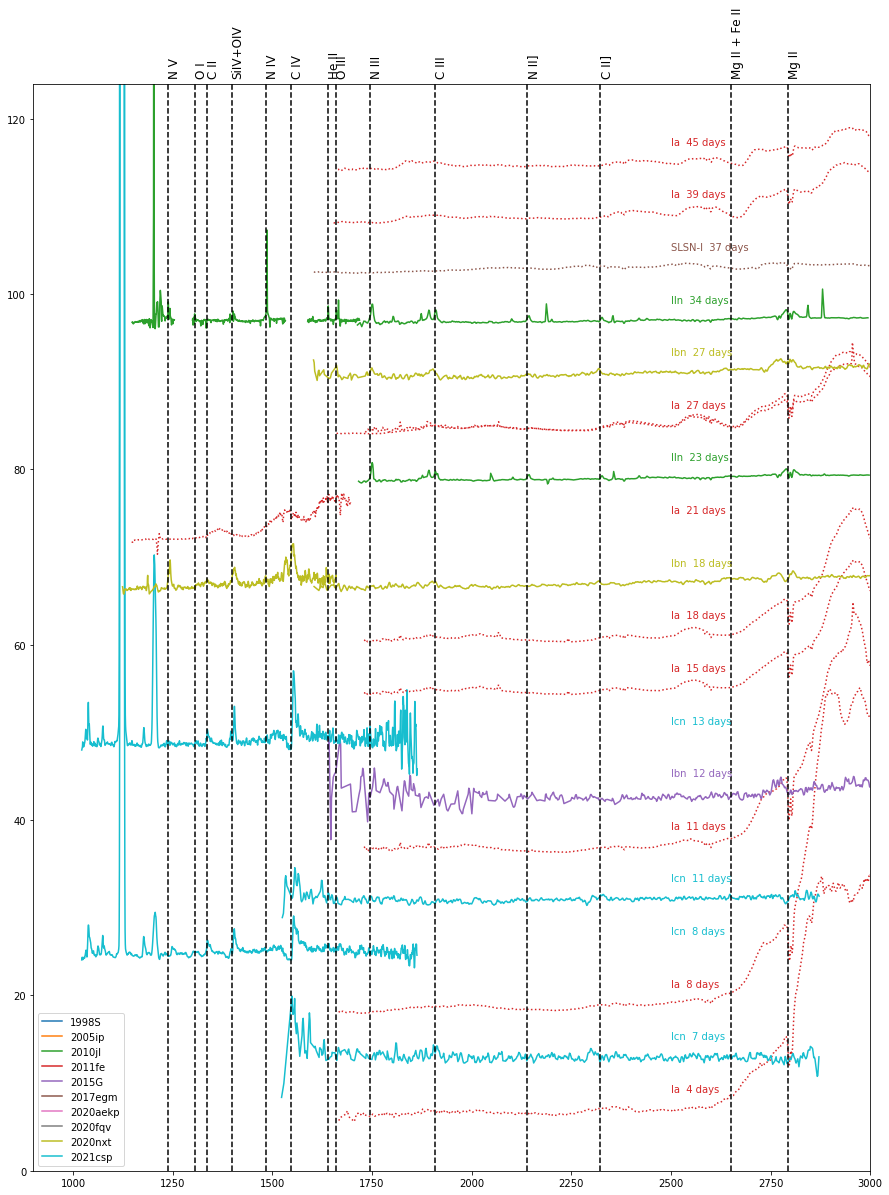

In [182]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 20))
g = Gaussian1DKernel(stddev=1)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']<50 and spec['name']!='2020fqv':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>2.1) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=6
            plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    
        if spec['name'] == '2021csp' and 'FUV' in spec['file']:
#            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 8)
        elif (spec['name'] == '2010jl' and (('FUV' in spec['file'])or('MUV' in spec['file']))):
#            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 32)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)



xcoords=[1238, 1305.5, 1335, 1398,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V', 'O I', 'C II', 'SiIV+OIV' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(900, 3000)
plt.ylim(0, shift+10)
plt.legend()

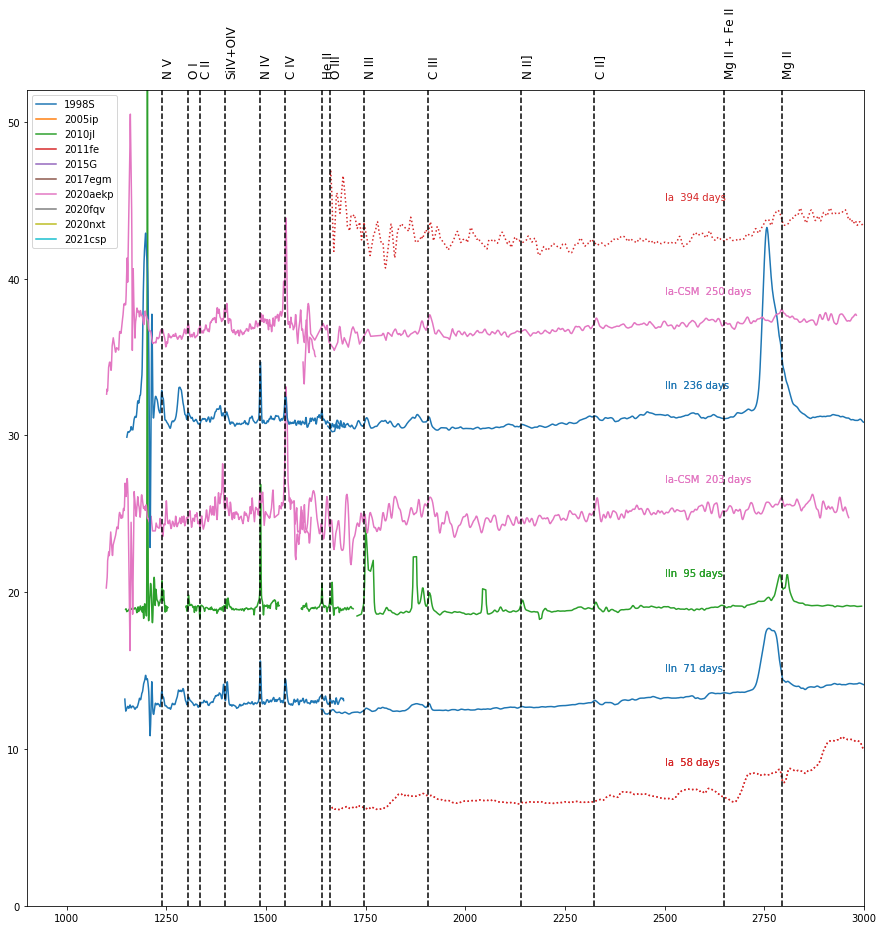

In [198]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 15))
g = Gaussian1DKernel(stddev=2)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']>50 and spec['phase']<400 and spec['name']!='2020fqv':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>1) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=6
        if (spec['name'] == '2021csp' and 'FUV' in spec['file']):
            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 16)
        elif (spec['name'] == '2010jl' and 'd604' in spec['file']):
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 32)
        elif (spec['name'] == '2010jl' and (('FUV' in spec['file'])or('MUV' in spec['file']))):
#            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 32)
        elif spec['file'] == './reduced_spectra/2020aekp/2020aekp_d203NUV_x1d.fits':
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle, domask = False)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)
        plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    


xcoords=[1238, 1305.5, 1335, 1398,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V', 'O I', 'C II', 'SiIV+OIV' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(900, 3000)
plt.ylim(0, shift+10)
plt.legend()

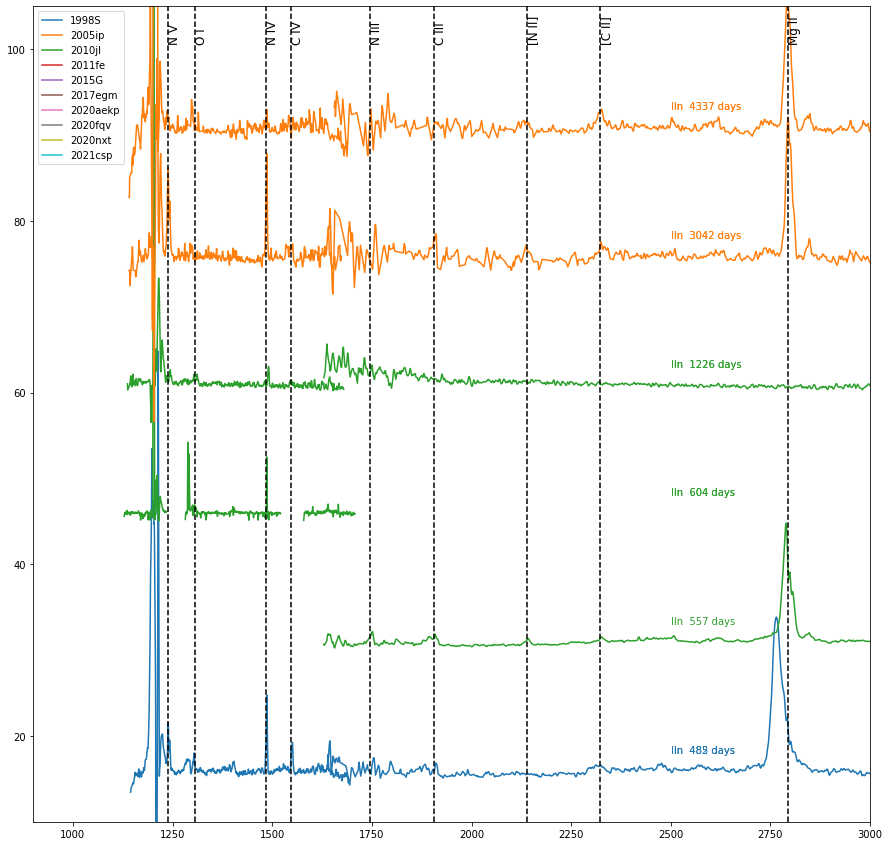

In [180]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 15))
g = Gaussian1DKernel(stddev=1)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']>400 and spec['name']!='2020fqv' and spec['file']!='./reduced_spectra/2010jl/2010jl_d1616NUV_x1d.fits':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>4) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=15
        if spec['name'] == '2021csp' and 'FUV' in spec['file']:
            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 16)
        elif (spec['name'] == '2010jl' and (('FUV' in spec['file'])or('MUV' in spec['file'])) and ('1226' not in spec['file'])):
#            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 32)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)
        plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    



xcoords=[1238, 1305.5,1484  ,1548  ,1746   ,1907   ,2139   ,2323, 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V', 'O I','N IV','C IV','N III','C III','[N II]','[C II]','Mg II']
       

for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(900, 3000)
plt.ylim(10, shift+15)
plt.legend()

In [63]:
len(wav)/16

934.5625

Text(0.5, 0, 'Wavelength ($\\AA$)')

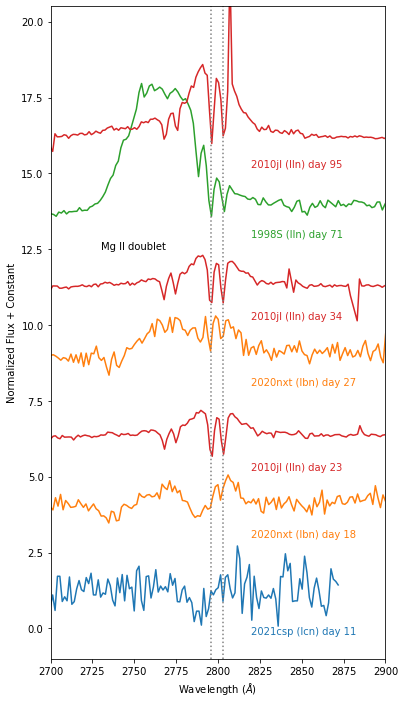

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6, 12))
g = Gaussian1DKernel(stddev=0.1)
g2 = Gaussian1DKernel(stddev=1)
gap = 2.5
with fits.open('./reduced_spectra/2021csp/2021csp_d11NUV.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2021csp']), flux[ind]/np.median(flux[ind])+0, color = 'C0', label = '2021csp')
axes.text(2820, -0.2,'2021csp (Icn) day 11', color = 'C0')    
    
#with fits.open('./reduced_spectra/2015G/2015G_d12NUV_x1d.fits') as f:
#    flux = convolve(f[1].data['FLUX'][0], g)
#    ind = f[1].data['WAVELENGTH'][0]>0
#    ind[:80]=False
#    ind[-50:]=False
#    axes[0].plot(f[1].data['WAVELENGTH'][0][ind]/(1+0), 
#                 convolve(flux[ind], g2)/np.median(flux[ind])+3, color = 'C1', label = '2021csp')
#    axes[1].plot(f[1].data['WAVELENGTH'][0][ind]/(1+0), 
#                 convolve(flux[ind], g2)/np.median(flux[ind])+3, color = 'C1', label = '2021csp')

#axes[0].text(1920, 5,'2015G (Ibn) days 12', color = 'C1')    
#axes[1].text(2800, 6,'2015G (Ibn) days 12', color = 'C1')    
#axes[1].text(2800, 6,'2015G (Ibn) days 12', color = 'C1')    

with fits.open('./reduced_spectra/2020nxt/2020nxt_d18NUV.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:40]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020nxt']), flux[ind]/np.median(flux[ind])+gap, color = 'C1', label = '2021csp')
axes.text(2820, gap+0.5,'2020nxt (Ibn) day 18', color = 'C1')    

with fits.open('./reduced_spectra/2010jl/2010jl_d23NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*2, color = 'C3', label = '2021csp')
axes.text(2820, gap*2+0.2,'2010jl (IIn) day 23', color = 'C3')    


with fits.open('./reduced_spectra/2020nxt/2020nxt_d27NUV.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:40]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020nxt']), flux[ind]/np.median(flux[ind])+gap*3, color = 'C1', label = '2021csp')
axes.text(2820, gap*3+0.5,'2020nxt (Ibn) day 27', color = 'C1')    

with fits.open('./reduced_spectra/2010jl/2010jl_d34NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = flux/np.median(flux)<3#f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*4, color = 'C3', label = '2021csp')
axes.text(2820, gap*4+0.2,'2010jl (IIn) day 34', color = 'C3')    

with fits.open('./reduced_spectra/1998S/1998s_d71NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap*5-0.5, color = 'C2', label = '2021csp')
axes.text(2820, gap*5+0.4,'1998S (IIn) day 71', color = 'C2')    

with fits.open('./reduced_spectra/2010jl/2010jl_d95NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*6, color = 'C3', label = '2021csp')
axes.text(2820, gap*6+0.2,'2010jl (IIn) day 95', color = 'C3')    

axes.axvline(2796, linestyle = ':', color = 'grey')
axes.axvline(2803, linestyle = ':', color = 'grey')
#axes[1].axvline(2796/(1+z_dict['2015G']), linestyle = ':', color = 'k')
#axes[1].axvline(2803/(1+z_dict['2015G']), linestyle = ':', color = 'k')

axes.text(2730, gap*5,'Mg II doublet', color = 'k')    
axes.set_ylim(-1, gap*7+3)
axes.set_xlim(2700, 2900)
axes.set_ylabel('Normalized Flux + Constant')
axes.set_xlabel(r'Wavelength ($\AA$)')

Text(0.5, 0, 'Wavelength ($\\AA$)')

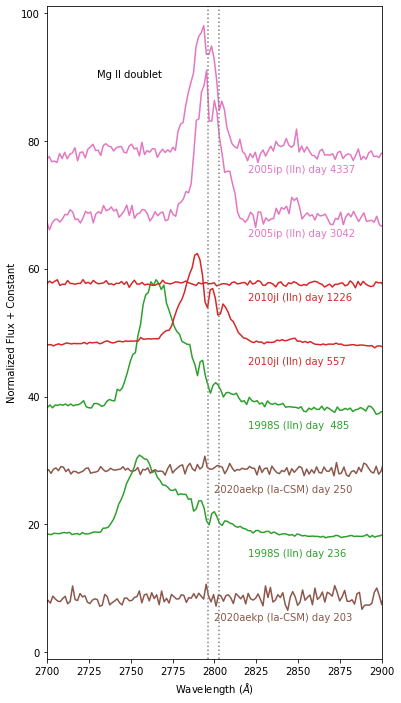

In [212]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6, 12))
g = Gaussian1DKernel(stddev=0.1)
g2 = Gaussian1DKernel(stddev=1)
gap = 10
yshift = 3

with fits.open('./reduced_spectra/2020aekp/2020aekp_d203NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:40]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020aekp']), flux[ind]/np.median(flux[ind])+gap-yshift, color = 'C5', label = '2021csp')
axes.text(2800, gap-5,'2020aekp (Ia-CSM) day 203', color = 'C5')    

with fits.open('./reduced_spectra/1998S/1998s_d236NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap*2-yshift, color = 'C2', label = '2021csp')
axes.text(2820, gap*2-5,'1998S (IIn) day 236', color = 'C2')    


with fits.open('./reduced_spectra/2020aekp/2020aekp_d250NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:40]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020aekp']), flux[ind]/np.median(flux[ind])+gap*3-yshift, color = 'C5', label = '2021csp')
axes.text(2800, gap*3-5,'2020aekp (Ia-CSM) day 250', color = 'C5')    

with fits.open('./reduced_spectra/1998S/1998s_d485NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap*4-yshift, color = 'C2', label = '2021csp')
axes.text(2820, gap*4-5,'1998S (IIn) day  485', color = 'C2')    

with fits.open('./reduced_spectra/2010jl/2010jl_d557NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*5-yshift, color = 'C3', label = '2021csp')
axes.text(2820, gap*5-5,'2010jl (IIn) day 557', color = 'C3')    

with fits.open('./reduced_spectra/2010jl/2010jl_d1226NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*6-yshift, color = 'C3', label = '2021csp')
axes.text(2820, gap*6-5,'2010jl (IIn) day 1226', color = 'C3')    

with fits.open('./reduced_spectra/2005ip/2005ip_d3042NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2005ip']), flux[ind]/np.median(flux[ind])+gap*7-yshift, color = 'C6', label = '2021csp')
axes.text(2820, gap*7-5,'2005ip (IIn) day 3042', color = 'C6')    

with fits.open('./reduced_spectra/2005ip/2005ip_d4337NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    axes.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2005ip']), flux[ind]/np.median(flux[ind])+gap*8-yshift, color = 'C6', label = '2021csp')
axes.text(2820, gap*8-5,'2005ip (IIn) day 4337', color = 'C6')    

axes.axvline(2796, linestyle = ':', color = 'grey')
axes.axvline(2803, linestyle = ':', color = 'grey')
#axes[1].axvline(2796/(1+z_dict['2015G']), linestyle = ':', color = 'k')
#axes[1].axvline(2803/(1+z_dict['2015G']), linestyle = ':', color = 'k')

axes.text(2730, gap*9,'Mg II doublet', color = 'k')    
axes.set_ylim(-1, gap*9+11)
axes.set_xlim(2700, 2900)
axes.set_ylabel('Normalized Flux + Constant')
axes.set_xlabel(r'Wavelength ($\AA$)')

Text(0.5, 0, 'Wavelength ($\\AA$)')

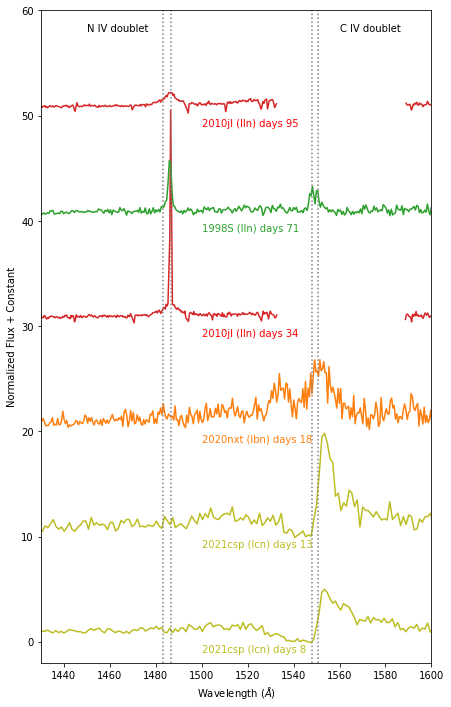

In [222]:
plt.figure(figsize=(7, 12))
gap = 10
yshift = 3

with fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits') as f:
    ind = f[1].data['DQ'][0]==0
    wav = f[1].data['WAVELENGTH'][0][ind]
    flux = f[1].data['FLUX'][0][ind]
    for i in range(int(len(wav)/16)):
        wav_bin[i] = np.average(wav[i*16:i*16+16])
        f_bin[i] = np.sum(flux[i*16:i*16+16])
    f_bin = convolve(f_bin, g)
    ind = wav_bin>0
    ind[:50]=False
    ind[-350:]=False
    plt.plot(wav_bin[ind]/(1+z_dict['2021csp']), convolve(f_bin[ind],g)/np.median(f_bin[ind]), color = 'C8')    
plt.text(1500, -1,'2021csp (Icn) days 8', color = 'C8')    

with fits.open('./reduced_spectra/2021csp/2021csp_d13FUV.fits') as f:
    ind = f[1].data['DQ'][0]==0
    wav = f[1].data['WAVELENGTH'][0][ind]
    flux = f[1].data['FLUX'][0][ind]
    for i in range(int(len(wav)/16)):
        wav_bin[i] = np.average(wav[i*16:i*16+16])
        f_bin[i] = np.sum(flux[i*16:i*16+16])
    f_bin = convolve(f_bin, g)
    ind = wav_bin>0
    ind[:50]=False
    ind[-350:]=False
    plt.plot(wav_bin[ind]/(1+z_dict['2021csp']), convolve(f_bin[ind],g)/np.median(f_bin[ind])+gap, color = 'C8')    
plt.text(1500, gap-1,'2021csp (Icn) days 13', color = 'C8')    

with fits.open('./reduced_spectra/2020nxt/2020nxt_d18FUV.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020nxt']), flux[ind]/np.median(flux[ind])+gap*2, color = 'C1', label = '2021csp')
plt.text(1500, gap*2-1,'2020nxt (Ibn) days 18', color = 'C1')    

#with fits.open('./reduced_spectra/2011fe/2011fe_d21FUV_x1d.fits') as f:
#    flux = convolve(f[1].data['FLUX'][0], g)
#    ind = f[1].data['WAVELENGTH'][0]>0
#    ind[:100]=False
#    ind[-100:]=False
#    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2011fe']), flux[ind]/np.median(flux[ind])+gap*3, color = 'C3', label = '2021csp')
#plt.text(1500, gap*3-1,'2011fe (Ia) days 21', color = 'C3')    


plot_spec('./reduced_spectra/2010jl/2010jl_d34FUV_x1d.fits', 'C3', g, shift = gap*3, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)
plot_spec('./reduced_spectra/2010jl/2010jl_d34MUV_x1d.fits', 'C3', g, shift = gap*3, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)

plt.text(1500, gap*3-1,'2010jl (IIn) days 34', color = 'r')    

with fits.open('./reduced_spectra/1998S/1998s_d71FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap*4, color = 'C2', label = '2021csp')
plt.text(1500, gap*4-1,'1998S (IIn) days 71', color = 'C2')    

plot_spec('./reduced_spectra/2010jl/2010jl_d95FUV_x1d.fits', 'C3', g, shift = gap*5, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)
plot_spec('./reduced_spectra/2010jl/2010jl_d95MUV_x1d.fits', 'C3', g, shift = gap*5, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)

plt.text(1500, gap*5-1,'2010jl (IIn) days 95', color = 'r')    


plt.axvline(1483.32, linestyle = ':', color = 'grey')
plt.axvline(1486.5, linestyle = ':', color = 'grey')

plt.axvline(1548.19, linestyle = ':', color = 'grey')
plt.axvline(1550.77, linestyle = ':', color = 'grey')

plt.ylim(-2, gap*6)
plt.xlim(1430, 1600)
plt.text(1450, gap*6-2,'N IV doublet', color = 'k')    
plt.text(1560, gap*6-2,'C IV doublet', color = 'k')    

plt.ylabel('Normalized Flux + Constant')
plt.xlabel(r'Wavelength ($\AA$)')

Text(0.5, 0, 'Wavelength ($\\AA$)')

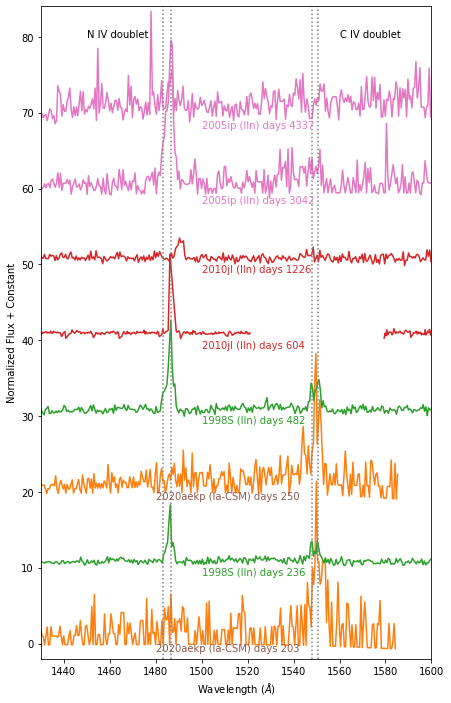

In [225]:
plt.figure(figsize=(7, 12))
gap = 10
yshift = 3


with fits.open('./reduced_spectra/2020aekp/2020aekp_d203FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020aekp']), flux[ind]/np.median(flux[ind]), color = 'C1', label = '2021csp')
plt.text(1480, -1,'2020aekp (Ia-CSM) days 203', color = 'C5')    


with fits.open('./reduced_spectra/1998S/1998s_d236FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap, color = 'C2', label = '2021csp')
plt.text(1500, gap-1,'1998S (IIn) days 236', color = 'C2')    

with fits.open('./reduced_spectra/2020aekp/2020aekp_d250FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2020aekp']), flux[ind]/np.median(flux[ind])+gap*2, color = 'C1', label = '2021csp')
plt.text(1480, gap*2-1,'2020aekp (Ia-CSM) days 250', color = 'C5')    

with fits.open('./reduced_spectra/1998S/1998s_d482FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['1998S']), flux[ind]/np.median(flux[ind])+gap*3, color = 'C2', label = '2021csp')
plt.text(1500, gap*3-1,'1998S (IIn) days 482', color = 'C2')    

plot_spec('./reduced_spectra/2010jl/2010jl_d604FUV_x1d.fits', 'C3', g, shift = gap*4, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)
plot_spec('./reduced_spectra/2010jl/2010jl_d604MUV_x1d.fits', 'C3', g, shift = gap*4, z = z_dict['2010jl'], linestyle = linestyle
                , bin_f = True, bin_size = 32)

plt.text(1500, gap*4-1,'2010jl (IIn) days 604', color = 'C3')    


with fits.open('./reduced_spectra/2010jl/2010jl_d1226FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2010jl']), flux[ind]/np.median(flux[ind])+gap*5, color = 'C3', label = '2021csp')
plt.text(1500, gap*5-1,'2010jl (IIn) days 1226', color = 'C3')    

with fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2005ip']), flux[ind]/np.median(flux[ind])+gap*6, color = 'C6', label = '2021csp')
plt.text(1500, gap*6-2,'2005ip (IIn) days 3042', color = 'C6')    

with fits.open('./reduced_spectra/2005ip/2005ip_d4337FUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-100:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z_dict['2005ip']), flux[ind]/np.median(flux[ind])+gap*7, color = 'C6', label = '2021csp')
plt.text(1500, gap*7-2,'2005ip (IIn) days 4337', color = 'C6')    

plt.axvline(1483.32, linestyle = ':', color = 'grey')
plt.axvline(1486.5, linestyle = ':', color = 'grey')

plt.axvline(1548.19, linestyle = ':', color = 'grey')
plt.axvline(1550.77, linestyle = ':', color = 'grey')

plt.ylim(-2, gap*8+4)
plt.xlim(1430, 1600)
plt.text(1450, gap*8,'N IV doublet', color = 'k')    
plt.text(1560, gap*8,'C IV doublet', color = 'k')    

plt.ylabel('Normalized Flux + Constant')
plt.xlabel(r'Wavelength ($\AA$)')